In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/Users/Jian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import re

In [3]:
import datetime

In [4]:
import os

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from plotting import *

In [7]:
LOSS_INDEX = 3

## Acquisition

#### Directory that contains all the experiment subdirectories

In [8]:
base_dir = '../knl-tuning-runs/log'

In [9]:
base_dir = '../knl-archive-runs/log_archive'

In [10]:
n_workers = 8

In [11]:
experiment_name = 'imagenet_tuning_W' + str(n_workers)

In [12]:
all_matching_experiments = []

In [13]:
for directory in os.walk(base_dir):
    if directory[0].startswith(base_dir + '/'+ experiment_name):
        all_matching_experiments.append(directory[0])
print 'Found the following matching experiments : '
print '\n'.join(all_matching_experiments)

Found the following matching experiments : 



### Either let the script pick the most recent matching experiment, 

In [14]:
if len(all_matching_experiments)==0:
    print 'No experiments matching prefix ' + experiment_name
    experiment_directory = None
else:
    experiment_directory = [sorted(all_matching_experiments)[-1]]
    if len(all_matching_experiments)>1:
        print 'Selecting ' + experiment_directory[0] + ' out of ' + str(len(all_matching_experiments)) + ' matching experiments.'
    else:
        print 'Selecting ' + experiment_directory[0]

No experiments matching prefix imagenet_tuning_W8


### Or manually sellect one,

In [15]:
experiment_directory=['../knl-imit-runs/log/imagenet_tuning_W8_2016-10-22-21:50']

### Or manually sellect many

In [16]:
experiment_directory=['../cifar10/log/tuning_W8_2016-10-16-00:41',
                      '../cifar10/log/tuning_W8_2016-10-16-13:11'
                      ]

### Or manually sellect all

In [19]:
experiment_directory = all_matching_experiments


# experiment_directory=['/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight']
experiment_directory=experiment_directory=['/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/current_experiment']

### Load logs from selected experiment

In [20]:
parameter_values = {}

all_configs = []

if not type(experiment_directory) == list:
    experiment_directory = [experiment_directory]

for this_exp_dir in experiment_directory:
    print
    print 'From directory ' + this_exp_dir
    for fname in os.listdir(this_exp_dir):
        if fname[-4:]!='.log':
            print fname
            continue
#         if "LR=0.01" not in fname:
#             continue
#         if "mu=0.3" not in fname:
#             continue
#         if "G=2" not in fname:
#             continue
        assert(fname[-4:]=='.log')
        parameter_strings = fname[:-4].split('_')
        print 'Loading ' + fname
        for pstring in parameter_strings:
            p,v = pstring.split('=')
            parameter_values[p] = float(v)
            if p=='W':
                assert(int(v)==n_workers)
        print this_exp_dir + '/' + fname
        all_lines = load_results(this_exp_dir + '/' + fname)
        all_configs.append([parameter_values.copy(), all_lines])


From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/current_experiment
Loading W=8_G=1_LR=0.001_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/current_experiment/W=8_G=1_LR=0.001_mu=0.0.log
Loading W=8_G=1_LR=0.001_mu=0.3.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/current_experiment/W=8_G=1_LR=0.001_mu=0.3.log
Loading W=8_G=1_LR=0.001_mu=0.6.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/current_experiment/W=8_G=1_LR=0.001_mu=0.6.log
Loading W=8_G=1_LR=0.001_mu=0.9.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/current_experiment/W=8_G=1_LR=0.001_mu=0.9.log
Loading W=8_G=1_LR=0.003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/cifar10/log_archive/current_experiment/W=8_G=1_LR=0.003_mu=0.0.log
Loading W=8_G=1_LR=0.003_mu=0.3.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experi

In [21]:
# all_configs

## Plot all configs

In [22]:
W = 1

In [23]:
import matplotlib.cm as cm

{'mu': 0.0, 'LR': 0.003, 'W': 8.0, 'G': 8.0}  run too short. Was is terminated?
{'mu': 0.3, 'LR': 0.003, 'W': 8.0, 'G': 8.0}  run too short. Was is terminated?
{'mu': 0.6, 'LR': 0.003, 'W': 8.0, 'G': 8.0}  run too short. Was is terminated?


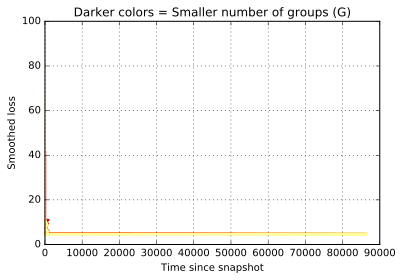

In [24]:
for config in all_configs:
    G = int(config[0]['G'])
    losses_per_batch = int(np.round(float(n_workers)/G))
    
    if len(config[1]) < 2*W*losses_per_batch:
        print config[0], ' run too short. Was is terminated?'
        continue

    all_seconds, all_losses = get_times_losses(config[1])

    plt.plot(all_seconds, moving_average(all_losses,window_size=W*losses_per_batch),
             '-',linewidth=2, label=str(config[0]), 
             color=cm.hot((config[0]['G']+1.0)/float(n_workers+2)) )
plt.grid()
#plt.axis([None, None, 0.7, 1.0]);
plt.title('Darker colors = Smaller number of groups (G)')
plt.ylabel('Smoothed loss')
plt.xlabel('Time since snapshot')

### Plots best configs per group 

In [92]:
best_configs = get_best_config_per_group(n_workers, all_configs,W=10)

{'mu': 0.0, 'LR': 0.003, 'W': 8.0, 'G': 8.0}  run too short. Was is terminated?
{'mu': 0.3, 'LR': 0.003, 'W': 8.0, 'G': 8.0}  run too short. Was is terminated?
{'mu': 0.6, 'LR': 0.003, 'W': 8.0, 'G': 8.0}  run too short. Was is terminated?


8 4201
4 6822
2 6846
1 6358


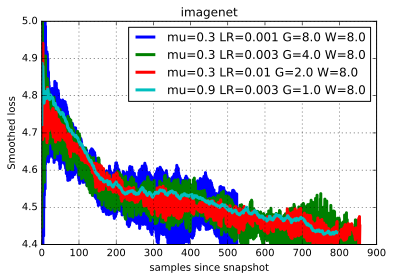

In [95]:
for G in reversed(sorted(best_configs.keys()) ):
    config = best_configs[G]
    all_seconds, all_losses = get_times_losses(config[1])
    losses_per_batch = int(np.round(float(n_workers)/G))
#     print G, losses_per_batch
#     all_batches = np.arange(len(all_losses))/losses_per_batch
#     plt.plot(all_batches, moving_average(all_losses,window_size=W*losses_per_batch),
#              '-',linewidth=3,
#              label=' '.join([p+'='+str(config[0][p]) for p in config[0]])

    print G, len(all_losses)

    n_iter = int(np.floor(len(all_seconds) / losses_per_batch) )
    all_seconds = all_seconds[0:(n_iter *  losses_per_batch) ]
    all_losses = np.mean(np.array(all_losses[0:(n_iter * losses_per_batch) ] ).reshape([n_iter, losses_per_batch]), axis=1)

    plt.plot(np.arange(len(all_losses)) / G, all_losses,
             '-',linewidth=3,
             label=' '.join([p+'='+str(config[0][p]) for p in config[0]])
    )

plt.xlabel('samples since snapshot')
plt.ylabel('Smoothed loss')
plt.legend()
plt.grid()
plt.axis([None, None, 4.4, 5.0]);
# plt.axis([0, 200, 4.5, 4.9]);
plt.title("imagenet")

In [96]:
def get_he_se_numbers_from_log_lines(all_lines,n,g,group_batch=True):

    all_seconds, all_losses = get_times_losses(all_lines)

    iters =[line[2] for line in all_lines]
    
    if group_batch:
        # Each group is responsible of a mini-batch
        total_batches=g*(np.max(iters)-iters[0])
    else:
        # Each worker is responsible for a mini-batch
        total_batches=n*(np.max(iters)-iters[0])

    total_time = all_seconds[-1]

    seconds_per_batch = total_time/total_batches
    
    return seconds_per_batch, total_batches, total_time



## Set numbers of groups to focus on here

In [97]:
all_g = [1,2,4,8]

In [98]:
for G in all_g:
    print get_he_se_numbers_from_log_lines(best_configs[G][1], n_workers, G, group_batch=False)

(0.13117092647984888, 6352, 833.197725)
(0.12361956722933642, 6872, 849.513666)
(0.10646957064075631, 7616, 810.87225)
(0.19679288224299066, 4280, 842.273536)


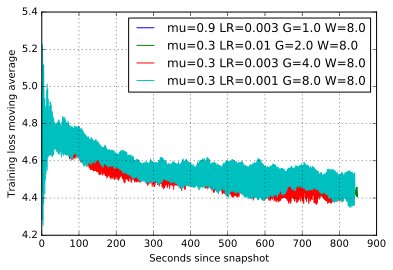

In [99]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
for G in all_g:
    losses_per_batch = int(np.round(float(n_workers)/G))
    Weff = W*losses_per_batch
    all_lines = best_configs[G][1]
    seconds, losses = get_times_losses(all_lines)
    plt.plot(seconds,moving_average(losses,Weff),
             label=' '.join([p+'='+str(best_configs[G][0][p]) for p in best_configs[G][0]])
    )

plt.xlabel('Seconds since snapshot')
plt.ylabel('Training loss moving average')
plt.legend()
plt.grid()
#plt.axis([None, None, 0.7, 0.9])

### Calculate the target loss: lowest loss achieved by all configurations

In [100]:
all_losses=[]
all_seconds=[]
max_min_loss = -np.inf
for G in all_g:
    losses_per_batch = int(np.round(float(n_workers)/G))
    all_lines = best_configs[G][1]
    seconds, losses = get_times_losses(all_lines)
    losses = moving_average(losses, W*losses_per_batch)
    all_losses.append(losses)
    all_seconds.append(seconds)
    if np.nanmin(losses)>max_min_loss:
        max_min_loss = np.nanmin(losses)
print max_min_loss

4.41842921875


### Estimate the time (in seconds) it took each configuration to reach this target loss

In [101]:
assert(not np.isinf(max_min_loss))
all_crossings =[]
for gi in range(len(all_g)):
    G=all_g[gi]
    losses_per_batch = int(np.round(float(n_workers)/G))
    Weff = W*losses_per_batch
    losses = all_losses[gi]
    seconds = all_seconds[gi]
    crossing_index = np.nonzero(losses[Weff:-Weff]<=max_min_loss)[0][0]+Weff
    crossing_time = seconds[crossing_index]
    #crossing_time = seconds[np.nonzero(losses[W:-W]<=max_min_loss)[0][0]+W]
    all_crossings.append(crossing_time)

In [102]:
all_crossings

[795.234472, 722.38164, 496.129767, 0.577842]

### Calculate how many iterations (batches) were required to reach target loss 

In [103]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
all_batches_to_target=[]
for gi in range(len(all_g)):
    g=all_g[gi]
    spb, tb, tt = get_he_se_numbers_from_log_lines(best_configs[g][1], n_workers, g)
    #get_he_se_numbers(experiment_name,4,g)
    all_seconds_per_batch.append(spb)
    all_total_batches.append(tb)
    all_total_time.append(tt)
    all_batches_to_target.append(np.ceil(all_crossings[gi]/spb))
    

In [104]:
all_batches_to_target

[758.0, 1461.0, 2330.0, 3.0]

### Hardware efficiency

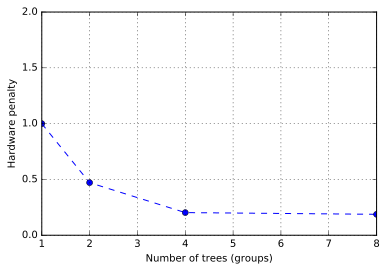

In [105]:
plt.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
plt.grid()
plt.ylabel('Hardware penalty')
plt.axis([None, None, 0, 2]);
plt.xlabel('Number of trees (groups)')

In [106]:
all_seconds_per_batch

[1.049367411838791,
 0.4944782689173457,
 0.21293914128151262,
 0.19679288224299066]

### Statistical efficiency 

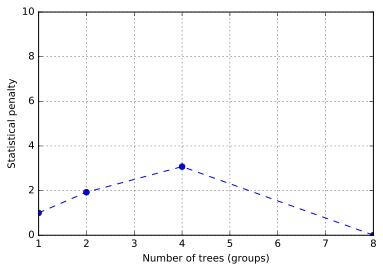

In [107]:
plt.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
plt.grid()
plt.ylabel('Statistical penalty')
plt.axis([None, None, 0, 10])
plt.xlabel('Number of trees (groups)')

### Efficiency Triplet 

In [60]:
def plot_he(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
    ax.grid()
    ax.set_ylabel('Hardware penalty')
    ax.axis([None, None, 0, 2]);
    ax.set_xlabel('# groups')

In [61]:
def plot_se(ax):
    ax.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
    ax.grid()
    ax.set_ylabel('Statistical penalty')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


In [62]:
def plot_relative_time(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)*np.array(all_batches_to_target)/(all_batches_to_target[0]*all_seconds_per_batch[0]), 'o--')
    ax.grid()
    ax.set_ylabel('Relative time')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


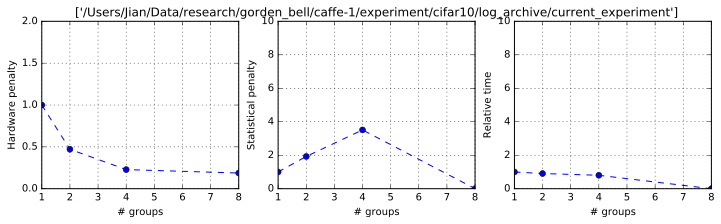

In [63]:
f,ax=plt.subplots(1,3,sharey=False, figsize=(12,3))
plot_he(ax[0])
plot_se(ax[1])
plot_relative_time(ax[2])
ax[1].set_title(experiment_directory);

In [207]:
all_seconds_per_batch

[5.585445833992095, 2.1680939055727553, 1.2040026623376625, 1.418444371124031]

In [61]:
int(np.ceil(50/float(60)))

1

In [82]:
import numpy as np

In [84]:
a = np.random.randn(3,2)

In [87]:
a.ravel()[0]

-0.23193500830132188

In [90]:
print("%.12f" % np.pi)

3.141592653590
